# Plots

Code to produce the plots from the ASPIRE paper.

In [ ]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path

from pesummary.io import read as pesummary_read
from pesummary.core.plots.seaborn.kde import kdeplot
from pesummary.utils.bounded_1d_kde import bounded_1d_kde
from pesummary.utils.utils import jensen_shannon_divergence_from_samples, mute_logger
from scipy.stats import gaussian_kde

import yaml

from pesummary.gw.plots.latex_labels import GWlatex_labels

import h5py

import warnings

from aspire_analysis_tools.gw.pesummary import extract_prior_bounds
from aspire_analysis_tools.utils import read_make_config

plt.style.use("plots.style")
plt.rcParams["text.usetex"] = False

bilby.core.utils.setup_logger(log_level="WARNING")
# Mute pesummary logging
mute_logger()

# Add a label for eccentricity
GWlatex_labels["eccentricity"] = r"$e_{20{\rm{Hz}}}$"



In [34]:
output = Path("figures")
output.mkdir(exist_ok=True)

## Data loading

Load the config file, this has the paths to the various results need to 
make the plots.

In [35]:
make_config = read_make_config("config.mk")

Load the YAML file that contains the paths to all the result files.

This file contains are overall name for each analysis and result files grouped
by the waveform used.

If running this after downloading the data release, you can use the
`results_first_paper.yaml` file in the `data_release` directory.

In [36]:
with open(make_config["RESULTS_MAPPING"], "r") as f:
    result_paths = yaml.safe_load(f)

# Recursively convert paths to pathlib Paths
for key, value in result_paths.items():
    for subkey, subvalue in value.items():
        for subsubkey, subsubvalue in subvalue.items():
            result_paths[key][subkey][subsubkey] = Path(subsubvalue)

Load the result files using `pesummary`.

Creates a set of nested dictionaries with analyses grouped by analysis and waveform.

In [37]:
results = {}
stats = {}
prior_bounds = {}
for label, wf_result_files in result_paths.items():
    results[label] = {}
    stats[label] = {}
    prior_bounds[label] = {}
    for waveform, result_files in wf_result_files.items():
        results[label][waveform] = {}
        stats[label][waveform] = {}
        prior_bounds[label][waveform] = {}
        for sampler, result_file in result_files.items():
            results[label][waveform][sampler] = pesummary_read(str(result_file), disable_prior=True)
            prior_bounds[label][waveform][sampler] = {}
            stats[label][waveform][sampler] = {
                "evals": None,
                "time": None,
                "log_evidence": None,
                "log_evidence_err": None,
                "n_posterior_samples": None
            }
            try:
                with h5py.File(result_file, "r") as f:
                    prior_bounds[label][waveform][sampler] = extract_prior_bounds(f["priors"][()])
                    stats[label][waveform][sampler]["evals"] = f["num_likelihood_evaluations"][()]
                    stats[label][waveform][sampler]["time"] = f["sampling_time"][()]
                    stats[label][waveform][sampler]["log_evidence"] = f["log_evidence"][()]
                    stats[label][waveform][sampler]["log_evidence_err"] = f["log_evidence_err"][()]
                    stats[label][waveform][sampler]["n_posterior_samples"] = len(f["posterior/chirp_mass"][()])
            except (KeyError, OSError):
                pass



/mnt/lustre2/shared_conda/envs/mjwill/aspire/lib/python3.11/site-packages/pesummary/gw/file/formats/base_read.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(np.atleast_1d(item)[0]):
/mnt/lustre2/shared_conda/envs/mjwill/aspire/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/mnt/lustre2/shared_conda/envs/mjwill/aspire/lib/python3.11/site-packages/pesummary/core/file/formats/base_read.py:142: ComplexWarning: Casting complex values to real discards the imaginary part
  [math.isnan(_) for _ in likelihoods], dtype=bool
/mnt/lustre2/shared_conda/envs/mjwill/aspire/lib/python3.11/site-packages/pesummary/gw/file/formats/base_read.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(np.atleast_1d(item)[0]):
/mnt/lustre2/shared_conda/e

## Jensen-Shannon Divergence

Compute the Jensen-Shannon Divergence for the parameters should in the plots.

We use `pesummary` to compute the JSD and only compute it for analyses that use
the same data and waveform.

In [38]:
parameters_of_interest = [
    "chirp_mass",
    "mass_ratio",
    "chi_eff",
    "chi_p",
    "eccentricity",
]

# Use natural log for JSD calculation
base = np.e

jsd = {}
for label, wf_results in results.items():
    jsd[label] = {}
    for waveform, sampler_results in wf_results.items():
        jsd[label][waveform] = {}
        samplers = list(sampler_results.keys())
        for i in range(len(samplers)):
            for j in range(i + 1, len(samplers)):
                sampler1 = samplers[i]
                sampler2 = samplers[j]
                key = f"{sampler1} vs {sampler2}"
                jsd[label][waveform][key] = {}
                samples1 = sampler_results[sampler1].samples_dict
                samples2 = sampler_results[sampler2].samples_dict
                samples1["cos_theta_jn"] = np.cos(samples1["theta_jn"])
                samples2["cos_theta_jn"] = np.cos(samples2["theta_jn"])
                for param in parameters_of_interest:
                    bounds = prior_bounds[label][waveform][sampler1].get(param, None)
                    if param == "cos_theta_jn":
                        bounds = (-1, 1)
                    if bounds is None or param in ["theta_jn"]:
                        kde = gaussian_kde
                        kde_kwargs = {}
                    else:
                        kde = bounded_1d_kde
                        kde_kwargs = {
                            "xlow": bounds[0],
                            "xhigh": bounds[1],
                            "method": "Reflection"
                        }
                    if param in samples1 and param in samples2:
                        jsd_value = jensen_shannon_divergence_from_samples(
                            [samples1[param].astype(float), samples2[param].astype(float)],
                            base=base,
                            kde=kde,
                            **kde_kwargs
                        )
                        jsd[label][waveform][key][param] = jsd_value
                    else:
                        jsd[label][waveform][key][param] = None

/tmp/ipykernel_3318535/2983570211.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  [samples1[param].astype(float), samples2[param].astype(float)],


## Utility functions

We define two helper functions to simplify making the plots.

In [51]:
def add_kde_plot_to_ax(ax, samples, bounds, linestyle="-", colour="C0", xlabel=None, jsd_value=None): 
    # If bounds are defined, use bounded_1d_kde
    if bounds[0] is not None and bounds[1] is not None:
        kde_kernel = bounded_1d_kde
        kde_kwargs = {
            "xlow": bounds[0],
            "xhigh": bounds[1],
            "method": "Reflection"
        }
    else:
        kde_kernel = None
        kde_kwargs = {}
    kde_kernel = None
    kde_kwargs = {}
    kdeplot(
        x=samples,
        ax=ax,
        color=colour,
        alpha=1.0,
        kde_kernel=kde_kernel,
        kde_kwargs=kde_kwargs,
        clip=bounds if bounds[0] is not None and bounds[1] is not None else None,
        linewidth=1.5,
        linestyle=linestyle,
    )
    # Set x-label
    ax.set_xlabel(xlabel)
    # Include JSD as title
    if jsd_value is not None:
        ax.set_title(
            f"{1e3 * jsd_value:.2f} mnat",
            fontsize=8,
        )

In [52]:
def plot_results(
    results,
    analysis_keys,
    analyses_to_plot,  
    parameters,
    colors,
    linestyles,
):
    """Helper function to 1-d KDE plots for a set of results.
    
    Produces a grid of 1-d KDE plots for each parameter in `parameters` (columns)
    and each analysis in `analysis_keys` (rows). Each subplot contains the KDEs
    for each waveform and sampler combination specified in `analyses_to_plot`.
    """
    
    if isinstance(parameters, list):
        parameters = {k: parameters for k in analysis_keys}

    if len(analysis_keys) > 1:
        assert len(parameters[analysis_keys[0]]) == len(parameters[analysis_keys[1]])

    figsize = plt.rcParams["figure.figsize"].copy()
    figsize[1] = 0.6 * figsize[1] * len(analysis_keys)

    with plt.rc_context({
        'figure.constrained_layout.use': True,
        'xtick.labelsize': 8,
        'axes.labelpad': 2,
    }), warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)  # Ignore warnings from seaborn about KDE
        warnings.simplefilter("ignore", FutureWarning)  # Ignore warnings from bounded_1d

        fig, axs = plt.subplots(len(analysis_keys), len(parameters[analysis_keys[0]]), figsize=figsize)
        axs = np.atleast_2d(axs)

        for i, label in enumerate(analysis_keys):
            if label not in results:
                print(f"Skipping {label}")
                continue
            for waveform, samplers in analyses_to_plot[label].items():
                if waveform not in results[label]:
                    print(f"Skipping {waveform} for {label}")
                    continue
                for j, sampler in enumerate(samplers):
                    if sampler not in results[label][waveform]:
                        continue
                    res = results[label][waveform][sampler]
                    for k, parameter in enumerate(parameters[label]):
                        if parameter not in res.samples_dict:
                            continue
                        samples = res.samples_dict[parameter]
                        if np.unique(samples).size == 1:
                            # If all samples are the same, skip plotting
                            continue
                        if len(samples) > 0:
                            # Get the prior bounds
                            bounds = prior_bounds[label][waveform][sampler].get(parameter, (None, None))
                            # Get the JSD value if applicable
                            if len(samplers) > 1 and j == 1:
                                jsd_val = jsd[label][waveform].get(f"{samplers[0]} vs {samplers[1]}", {}).get(parameter, None)
                                if jsd_val is None:
                                    jsd_val = jsd[label][waveform].get(f"{samplers[1]} vs {samplers[0]}", {}).get(parameter, None)
                            else:
                                jsd_val = None
                            add_kde_plot_to_ax(
                                ax=axs[i, k],
                                samples=samples.to_numpy().real,
                                bounds=bounds,
                                linestyle=linestyles[waveform][sampler],
                                colour=colors[waveform][sampler],
                                xlabel=GWlatex_labels.get(parameter, parameter),
                                jsd_value=jsd_val,
                            )
        for ax in axs.flat:
            # Remove y-axis labels and ticks
            ax.set_yticklabels([])
            # Remove y-axis labels
            ax.yaxis.label.set_visible(False)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    return fig


## Changing waveform - Figure 2

The code below produces figure 2, which compares the posterior distributions obtained
with `aspire` and `dynesty`.

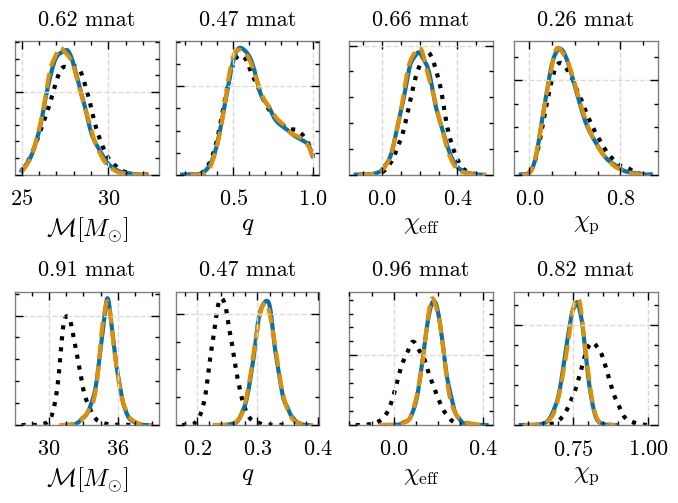

In [53]:
# Parameters to plot
parameters = ["chirp_mass", "mass_ratio", "chi_eff", "chi_p"]
# Which injections to plot
analysis_keys = ["GW150914-like", "q4"]
# Which results to plot
analyses_to_plot = {
    "IMRPhenomXPHM": ["dynesty"],
    "IMRPhenomXO4a": [
        "dynesty",
        "aspire from IMRPhenomXPHM",
    ],
}

analyses_to_plot = {k: analyses_to_plot for k in analysis_keys}

# Colors and linestyles for plotting
colors = {
    "IMRPhenomXPHM": {
        "dynesty": "k",
    },
    "IMRPhenomXO4a": {
        "dynesty": "C0",
        "aspire from IMRPhenomXPHM": "C1",
    },
    "SEOBNRv5PHM": {
        "aspire from IMRPhenomXPHM": "C2",
    }
}

ls = {
    "IMRPhenomXPHM": {
        "dynesty": ":",
    },
    "IMRPhenomXO4a": {
        "dynesty": "-",
        "aspire from IMRPhenomXPHM": "--",
    }, 
    "SEOBNRv5PHM": {
        "aspire from IMRPhenomXPHM": "-.",
    }
}

fig = plot_results(
    results,
    analysis_keys,
    analyses_to_plot,
    parameters,
    colors,
    ls,
)

plt.show()

fig.savefig(output / "changing_waveform.pdf", bbox_inches="tight")

## Adding physics - Figure 3

The code below produces figure 2, which compares the posterior distributions obtained
with `aspire` and `dynesty` when adding spin precession and orbital eccentricity.

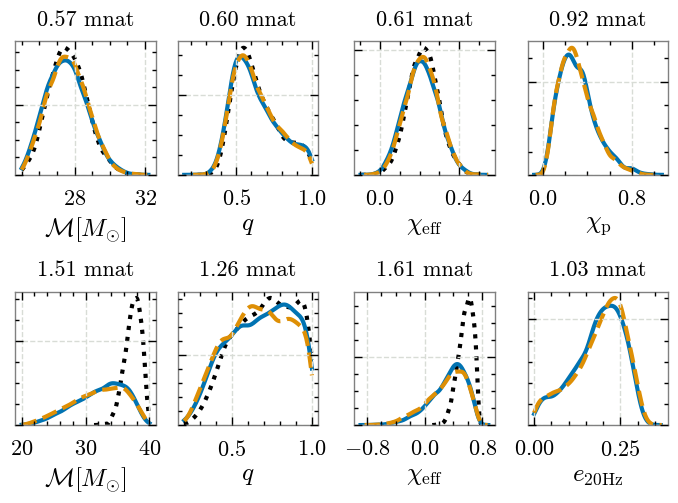

In [54]:
analysis_keys = ["GW150914-like", "eccentric"]

analyses_to_plot = {
    "GW150914-like": {
        "IMRPhenomD": ["dynesty"],
        "IMRPhenomPv2": ["dynesty", "aspire from IMRPhenomD"],
    },
    "eccentric": {
        "TaylorF2": ["dynesty"],
        "TaylorF2Ecc": ["dynesty", "aspire"],
    }
}
parameters = {
    "GW150914-like": ["chirp_mass", "mass_ratio", "chi_eff", "chi_p"],
    "eccentric": ["chirp_mass", "mass_ratio", "chi_eff", "eccentricity"],
}

colors = {
    "IMRPhenomD": {
        "dynesty": "k",
    },
    "IMRPhenomPv2": {
        "dynesty": "C0",
        "aspire from IMRPhenomD": "C1",
    },
    "TaylorF2": {
        "dynesty": "k",
    },
    "TaylorF2Ecc": {
        "dynesty": "C0",
        "aspire": "C1",
    },
}

ls = {
    "IMRPhenomD": {
        "dynesty": ":",
    },
    "IMRPhenomPv2": {
        "dynesty": "-",
        "aspire from IMRPhenomD": "--",
    },
    "TaylorF2": {
        "dynesty": ":",
    },
    "TaylorF2Ecc": {
        "dynesty": "-",
        "aspire": "--",
    }
}


fig = plot_results(
    results,
    analysis_keys,
    analyses_to_plot,
    parameters,
    colors,
    ls,
)
plt.show()

fig.savefig(output / "adding_physics.pdf", bbox_inches="tight")

## GW200129 - Figure 4

The code below produces the comparison for results obtained when analyzing
GW200129 using aspire and dynesty.

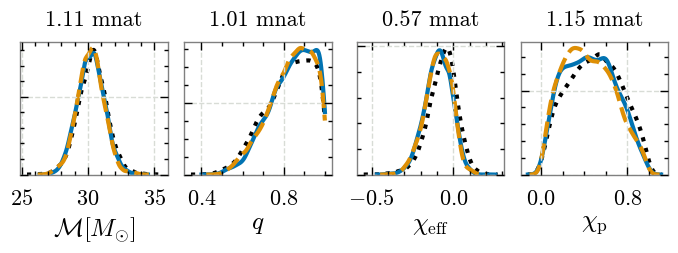

In [55]:

to_plot = {
    "IMRPhenomXPHM": [
        "dynesty",
    ],
    "IMRPhenomXO4a": [
        "dynesty",
        "aspire",
    ],
    # "SEOBNRv5PHM": [
    #     "dynesty",
    #     "aspire",
    # ]
}

colors = {
    "IMRPhenomXPHM": {
        "dynesty": "k",
    },
    "IMRPhenomXO4a": {
        "dynesty": "C0",
        "aspire": "C1",
    },
    "SEOBNRv5PHM": {
        "dynesty": "C0",
        "aspire": "C1",
    }
}

ls = {
    "IMRPhenomXPHM": {
        "dynesty": ":",
    },
    "IMRPhenomXO4a": {
        "dynesty": "-",
        "aspire": "--",
    },
    "SEOBNRv5PHM": {
        "dynesty": "-",
        "aspire": "--",
    },
}

analysis_keys = ["GW150914"]
analyses_to_plot = {
    "GW150914": to_plot,
}
parameters = {
    "GW150914": ["chirp_mass", "mass_ratio", "chi_eff", "chi_p"],
}

fig = plot_results(
    results,
    analysis_keys,
    analyses_to_plot,
    parameters,
    colors,
    ls,
)
plt.show()

fig.savefig(output / "GW150914.pdf", bbox_inches="tight")

In [56]:
# Write macros for JSD between chirp_mass, mass_ratio, chi_eff and chi_p
parameters = ["chirp_mass", "mass_ratio", "chi_eff", "chi_p"]
analysis_key = "GW150914"
filename = "jsd_macros.tex"
# Overwrite file
with open(filename, "w") as f:
    f.write("% Macros for JSD between different samplers\n")
    f.write("% Generated by change_waveform.ipynb\n")
for p in parameters:
    jsd_val = jsd[analysis_key]["IMRPhenomXO4a"].get("dynesty vs aspire", {}).get(p, None)
    if jsd_val is None:
        jsd_val = jsd[analysis_key]["IMRPhenomXO4a"].get("aspire vs dynesty", {}).get(p, None)
    if jsd_val is not None:
        with open(filename, "a") as f:
            name = f"JSD{p.capitalize().replace('_', '')}"
            f.write(f"\\newcommand{{\\{name}}}{{{1e3 * jsd_val:.2f}}}\n")

